# 2019 Winter STAT 231B --- Final Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with replay buffer on OpenAI Gym's Atari/box2d game. 

A very good official pytorch tutorial is a good start. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


You can choose any atari / box2d game you like under this two webpage: 

https://gym.openai.com/envs/#box2d

- [EASY] The box2d game state is the smallest. e.g. LunarLander-V2, it has only 8 dims.

https://gym.openai.com/envs/#atari

Each atari game has two kind of input. 
- [MEDIUM] RAM version has a small state of only 128 dims. You can use fully connected layer to train.
- [HELL] Screen version takes image as state which is around 200*200*3 dims. You need conv layer to train.

I recommended you try [EASY] first. If you make it all right, typical you will train a good agent within 1000 epochs. Then, try [MEDIUM].

[HELL] Screen version typically need 10 hour to train. (I failed in screen version) If you can train it successfully, I will definitely give you highest bouns.

Definition of solved : See https://github.com/openai/gym/wiki/Leaderboard

There are no specific definition of solved for atari game.

We only require you to implement [EASY]. Challange your self on atari game. 

Upload two files for coding part in Final.

- A pdf files : Your report. Please write down specific algorithm, implementing detail and result (Include sample game screenshot and reward-epoch plot) Also, attach all the code at the end of the pdf.

- This ipynb files. (If you use google colab for training, you do not need to upload. Instead, share this ipynb to me. Press "Share" in the top-right and coby the link to your readme.md)


- PS. You do not need to follow my template if you prefer implement in your way. 
- PPS. You can use Tensorflow if you prefer to do so. 
- However, please define the same class as this template. Include at least : 
agent class with act and learn; replay class with push and sample; q-function class with deep network structure; a train function.



## By Ruchen Zhen

## 1. Import the Necessary Packages

In [1]:
!pip install box2d-py
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
import gym
from gym import wrappers
import random
import torch
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
%matplotlib inline

def show_video(folder):
    mp4list = glob.glob('%s/*.mp4' % folder)
    if len(mp4list) > 0:
        encoded = base64.b64encode(io.open(mp4list[0], 'r+b').read())
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;"> 
        <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii'))))
        
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1081'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1081'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## 2. Try it

The following code will output a sample video whose action is random sampled.

In [3]:

atari_game = "Breakout-ram-v0"

lunar_lander = 'LunarLander-v2'

# env = gym.wrappers.Monitor(gym.make(atari_game), 'sample', force=True)

env = gym.wrappers.Monitor(gym.make(lunar_lander), 'sample', force=True)
env.seed(0)

state = env.reset()
cr = 0
for j in range(10):
    action = env.action_space.sample()
    print('Action: ', action)
    env.render()
    state, reward, done, _ = env.step(action)
    print('State: ', state)
    print('Reward: ', reward)
    print('Done: ',done)
    cr += reward
    print('\r %.5f' % cr, end="")
    if done:
        break 
env.close()
show_video('sample')

Action:  0
State:  [-1.1833191e-03  1.4154168e+00 -5.9854437e-02  8.7087154e-02
  1.3631723e-03  1.3419589e-02  0.0000000e+00  0.0000000e+00]
Reward:  1.940546167119379
Done:  False
 1.94055Action:  3
State:  [-1.6798973e-03  1.4167658e+00 -4.7912963e-02  5.9955612e-02
 -3.6131268e-04 -3.4492951e-02  0.0000000e+00  0.0000000e+00]
Reward:  2.827664829611764
Done:  False
 4.76821Action:  1
State:  [-2.2740364e-03  1.4175216e+00 -6.0160317e-02  3.3589985e-02
  3.7269565e-04  1.4681774e-02  0.0000000e+00  0.0000000e+00]
Reward:  0.6778045281137974
Done:  False
 5.44602Action:  0
State:  [-2.8683662e-03  1.4176774e+00 -6.0163099e-02  6.9215214e-03
  1.1050027e-03  1.4647315e-02  0.0000000e+00  0.0000000e+00]
Reward:  0.7453368792090203
Done:  False
 6.19135Action:  3
State:  [-3.3723831e-03  1.4172421e+00 -4.8845999e-02 -1.9346489e-02
 -4.3202651e-04 -3.0743504e-02  0.0000000e+00  0.0000000e+00]
Reward:  0.8829328506011234
Done:  False
 7.07429Action:  3
State:  [-0.00381289  1.4162128  -0.

In [4]:
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

print(env.observation_space)
print(env.action_space)
print(env.reward_range)
print(env.metadata)
print(env.spec)

State shape:  (8,)
Number of actions:  4
Box(8,)
Discrete(4)
(-inf, inf)
{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
EnvSpec(LunarLander-v2)


## 3. Define QNetwork, agent and replay buffer

In [0]:
BUFFER_SIZE = int(1e7)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 5        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### QNetwork

In [0]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.state_size = state_size
        self.action_size = action_size
        
        ## Layers of Q-Network
        self.hid1_fc = nn.Linear(state_size, fc1_units)
        self.hid2_fc = nn.Linear(fc1_units, fc2_units)
        self.outlayer = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.hid1_fc(state))
        x = F.relu(self.hid2_fc(x))
        out_scores = self.outlayer(x)
        
        return out_scores
        



### Replay Memory

In [0]:
from collections import namedtuple
import random

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        # Keep global parameters
        self.action_size = action_size # Not used yet
        self.buffer_capacity = buffer_size
        self.batch_size = batch_size
        self.seed = seed
        
        # Replay memory
        self.memory = []
    
    def push(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.memory.append(Transition(state, action, reward, next_state, done))
        # print(self.memory)
          
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        # random.seed(self.seed)
        # FUCK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # The FINAL FUCKING PROBLEM is that, if reset seed every time at here, 
        # 相当于，每次都用一样的随机，相当于完全没有随机，相当于每次都用一样的batch
        # 所以后面完全没在学东西
        # 所以gradient马上就全是0了
          
        transitions = random.sample(self.memory, self.batch_size)
        '''print('Batch_Transitions...')
        print(Batch_Transitions)'''
        
        Batch_Transitions = Transition(*zip(*transitions))
        
        # Return tuple of tensors
        
        '''print(type(Batch_Transitions))'''
        # print(type(Batch_Transitions.state))
        
        state_batch = torch.from_numpy(np.asarray(Batch_Transitions.state)).float().to(device).reshape((128,8))
        
        '''print(state_batch)'''
        
        action_batch = torch.from_numpy(np.asarray(Batch_Transitions.action)).to(device).reshape((128,1))
        reward_batch = torch.from_numpy(np.asarray(Batch_Transitions.reward)).float().to(device).reshape((128,1))
        next_state_batch = torch.from_numpy(np.asarray(Batch_Transitions.next_state)).float().to(device).reshape((128,8))
        
        temp_batch_dones = list(Batch_Transitions.done)
        temp_batch_dones = [ int(x) for x in temp_batch_dones ]

        done_batch = torch.from_numpy(np.asarray(temp_batch_dones)).float().to(device).reshape((128,1))
        
        '''print('Shapes')
        print(state_batch.shape)
        print(action_batch.shape)
        print(reward_batch.shape)
        print(next_state_batch.shape)
        print(done_batch.shape)'''

        
        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        # Return list of namedtuples
        '''return random.sample(self.memory, self.batch_size)'''
      
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        
        

### Agent

In [0]:
class Agent():
    """Interacts with and learns from the environment."""
    
    '''
    what the agent do: 
    for each episode:
      for each time step: 
        1. take action using Q Network: (1-eps) random, eps greedy --> act, call Q(state, action)
        2. observe and memorize: (state, action, reward, next state, done) --> step
        3. Learn --> learn, call ReplayBuffer.sample
        3.1 sample random minibatch of trasitions for learning 
        3.2 calculate y = reward_current_state + gamma*Q_best(next_state, best_action_next_state)
        3.3 compute Q(current state, surrent action)
        3.4 compute the loss (MSE) between y and Q(current state, surrent action)
        3.5 Do the gradient update for the weights of current state network
        
    '''
    

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        '''
        We have to keep two QNetworks. 
        As we are finding a Q-Function (for current_state, action pair) that statisfies the Bellman equation, 
        we will need a Q-Network for current state best Q-Func, 
        as well as a Q-Network for the next state best Q-Func. 
        Bellman Equation: policy_net = reward_current + GAMMA * target_net
        '''
        # Q-Network for current state action pair, to be learned and optimized
        self.policy_net = QNetwork(state_size, action_size, seed).to(device)
        
        # Q-Network for next state action pair, assume known in Bellman Equation
        self.target_net = QNetwork(state_size, action_size, seed).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        self.optimizer_policy_net = optim.Adam(self.policy_net.parameters(), lr = LR)
        
        



    
    def step(self, state, action, reward, next_state, done):
      
        # Agent work in a time step
        # 1. Memorize the trasition
        
        # print('Taking Step...')
        
        self.memory.push(state, action, reward, next_state, done)
        
        # 2. Sample a random minibatch of trasitions and learn

        if self.memory.__len__() > self.memory.batch_size:
          transitions = self.memory.sample()
          self.learn(transitions, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        # print('Taking Action...')
                
        # 1. Change the state to Tensor for NN
        # print(type(state))
        state = torch.from_numpy(np.array(state)).float().to(device)
        '''
        Cruical to change state to float here!!!!!!!!!!!! Otherwise: 
        RuntimeError: Expected object of scalar type Byte but got scalar type Float for argument #2 'mat2'
        https://stackoverflow.com/questions/49407303/runtimeerror-expected-object-of-type-torch-doubletensor-but-found-type-torch-fl
        '''
        
        # 2. Input state to Q-Net, obtain best action
        
        # Make sure Q-Net in on predict mode
        # print(type(self.policy_net))
        #self.policy_net.eval()
        
        # print('state: ', state.shape)
        Q_values = self.policy_net.forward(state).data
        
        #self.policy_net.train()
        # print('Q_values', Q_values)
                
        # 3. Take action: with eps greedy, with (1-eps) random
        if random.random() > eps:
          # Crucial to add .cpu()
          # TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
          best_action = np.argmax(Q_values.cpu().data.numpy())
          '''print('111')
          print(best_action)'''
        else:
          best_action = random.randint(0,3)
          '''print('222')
          print(best_action)'''
            
        return best_action
        

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        # print('Learning...')
        
        # 3.1 sample random minibatch of trasitions for learning
        # Has been done in step func
        states, actions, rewards, next_states, dones = experiences
        
        # 3.2 calculate y = reward_current_state + gamma*Q_best(next_state, best_action_next_state)
        # calculate ys
        # print(self.target_net)
        #self.target_net.eval()
        
        with torch.no_grad():
          Q_best_next = torch.max(self.target_net(next_states), dim = 1)[0].reshape((128,1))
          '''Attention: !!!!!!!!!!! torch.max() returns a tuple: (Tensor, LongTensor)'''
        
        #print('states: ', states.shape)
        #print('actions: ', actions.shape)
        #print('Rewards: ',rewards.shape)
        # print(type(Q_best_next))
        # y are different for the final state
        # print('Done: ', dones.shape)
        
        
        '''if dones == 1:
          y = rewards
          print('111')
        else: 
          y = rewards + GAMMA * Q_best_next
          print('222')'''
        
        expected_state_action_Q_values = rewards + (1-dones)*GAMMA * Q_best_next
          
        # 3.3 compute Q(current state, current action)
        
        # self.policy_net.eval()
        # current_state_action_Q_values = torch.max(self.policy_net(states), dim = 1)[0]
        current_state_action_Q_values = self.policy_net.forward(states).gather(1, actions)


        
        # 3.4 compute the loss (MSE) between y and Q(current state, surrent action)
        
        #print('y: ', y.shape)
        #print('Q_theta: ', Q_theta.shape)
        #self.policy_net.train()
        
        loss = F.smooth_l1_loss(expected_state_action_Q_values, current_state_action_Q_values)
        #print(loss)
        
        # 3.5 Do the gradient update for the weights of current state network
        
        #self.target_net.train()
        
        # Set Optimizer
        #optimizer_policy_net = optim.Adam(self.policy_net.parameters(), lr = LR)
        
        # Take Gradient Step
        self.optimizer_policy_net.zero_grad()
        
        
        loss.backward()
        
        '''for param in self.policy_net.parameters():
          print('gradients....')
          print(param.grad.data)
          param.grad.data.clamp_(-1, 1)'''
        
        self.optimizer_policy_net.step()
        
        # Soft update the parameters of target Q-Network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        
    
    

        
        

               


## 3. Train the Agent with DQN



Episode 0	Average Score: -404.66

Episode 0	Average Score: -404.66
Episode 100	Average Score: -113.67

Episode 100	Average Score: -113.67
Episode 200	Average Score: -16.26

Episode 200	Average Score: -16.26
Episode 300	Average Score: 76.49

Episode 300	Average Score: 76.49
Episode 400	Average Score: 90.30

Episode 400	Average Score: 90.30
Episode 500	Average Score: 196.79

Episode 500	Average Score: 196.79
Episode 516	Average Score: 201.00
Environment solved in 416 episodes!	Average Score: 201.00


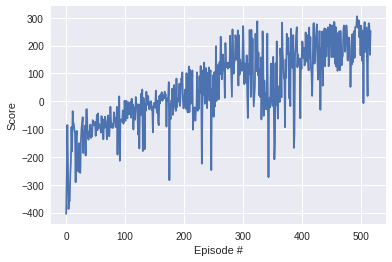

In [9]:
lunar_lander = 'LunarLander-v2'
# torch.set_default_tensor_type('torch.DoubleTensor')



def train(n_episodes=700, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    env = gym.wrappers.Monitor(gym.make(lunar_lander), 'output', force=True)
    
    render = True
    for i_episode in range(0, n_episodes):
        if render and i_episode % 100 == 0:
            env = gym.wrappers.Monitor(gym.make(lunar_lander), 'output_%d' % i_episode, force=True)
        state = env.reset()
        score = 0
        for t in range(max_t):
            # print('Time step ',t)
            action = agent.act(state, eps)
            if render and i_episode % 100 == 0:
                env.render()
            # print('running_action:', action)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            if render:
                env.close()
                show_video('output_%d' % i_episode)
                env = gym.make(lunar_lander)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0: # You can change for different game
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.policy_net.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=123)

scores = train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


You can load the parameter by this line.

In [0]:
# agent.policy_net.load_state_dict(torch.load('checkpoint.pth'))